## Assignment 01: Cluster analysis on gene expression data

### 1. Data Download and Preprocessing

In [1]:
# library
import pandas as pd
import polars as pl
import numpy as np
from tqdm import tqdm
from sklearn import cluster
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import os

from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.metrics import normalized_mutual_info_score as nmi

In [12]:
# download the data
# tpm data
tpm_url = "https://storage.googleapis.com/adult-gtex/bulk-gex/v8/rna-seq/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz"
tpm_file_path = "GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz"
tpm_cmd = f"curl --output {tpm_file_path} {tpm_url}"
os.system(tpm_cmd)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1550M  100 1550M    0     0  20.2M      0  0:01:16  0:01:16 --:--:-- 20.3M


0

In [13]:
# metadata
meta_url = "https://storage.googleapis.com/adult-gtex/annotations/v8/metadata-files/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt"
meta_file_path = "GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt"
meta_cmd = f"curl --output {meta_file_path} {meta_url}"
os.system(meta_cmd)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.9M  100 10.9M    0     0  13.5M      0 --:--:-- --:--:-- --:--:-- 13.5M


0

In [2]:
# load metadata files
metadata_df = pd.read_csv(
    "GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", 
    sep='\t'
)
print(metadata_df[metadata_df.SAMPID == "GTEX-1117F-0003-SM-58Q7G"]['SMTS'])

0    Blood
Name: SMTS, dtype: object


In [3]:
# Load TPM data
tpm_lazy_df = pl.read_csv(
    source = "GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz", 
    separator = "\t", 
    skip_rows = 2
) 

In [4]:
# Create a subset of the data we will work on
# - Use the metadata file to select the top 10 tissues with the largest sample size.
top_10_tissues = metadata_df.SMTS.value_counts().nlargest(10).reset_index()[['SMTS']].values.flatten()
print(f'Top ten tissues by sample size: \n  {top_10_tissues}')

# - only keep the columns for top 10 tissues
top_10_tissues_ids = np.unique(metadata_df[metadata_df.SMTS.isin(top_10_tissues)].SAMPID.values)
print(f"The ids for top 10 tissues are: {len(top_10_tissues_ids)}")
# - only get those IDs present in tpm count data
tpm_df_colums = np.array(tpm_lazy_df.columns)
top_10_tissues_ids = [ tissue_id for tissue_id in top_10_tissues_ids if tissue_id in tpm_df_colums]

print(f"The ids for top 10 tissues are and in tpm data: {len(top_10_tissues_ids)}")
top_10_tissues_ids.insert(0, "Name")
# only subset the data from top 10 tissues
top_10_tissues_subset = tpm_lazy_df.select(top_10_tissues_ids)
print(top_10_tissues_subset.shape)

Top ten tissues by sample size: 
  ['Blood' 'Brain' 'Skin' 'Esophagus' 'Blood Vessel' 'Adipose Tissue'
 'Heart' 'Muscle' 'Lung' 'Colon']
The ids for top 10 tissues are: 17163
The ids for top 10 tissues are and in tpm data: 12385
(56200, 12386)


In [5]:
# Use the bulk tissue expression file to select the top 5,000 most variable genes.
genes_vars = {}
for row_idx in tqdm(range(top_10_tissues_subset.shape[0])):
    row = top_10_tissues_subset.row(row_idx)
    gene_ensembl_id = row[0]
    # min max of the rows
    gene_exp = row[2:]
    normalized_gene_exp = (gene_exp - np.min(gene_exp)) / (np.max(gene_exp) - np.min(gene_exp))
    genes_vars[gene_ensembl_id] = np.var(row[2:])

  0%|                                        | 20/56200 [00:01<49:24, 18.95it/s]/var/folders/rd/c2tlh0qn3y7fvt1bwwd_d2x80000gn/T/ipykernel_78001/1486303560.py:8: RuntimeWarning: invalid value encountered in divide
  normalized_gene_exp = (gene_exp - np.min(gene_exp)) / (np.max(gene_exp) - np.min(gene_exp))
100%|████████████████████████████████████| 56200/56200 [04:54<00:00, 190.89it/s]


In [6]:
# get the top 5,000 most variable genes
from operator import itemgetter
topk = 5000
topk_genes = sorted(genes_vars.items(), key=itemgetter(1), reverse=True)[:topk]
most_variables_genes = [k[0] for k in topk_genes]
print(most_variables_genes[:10])

['ENSG00000244734.3', 'ENSG00000210082.2', 'ENSG00000198804.2', 'ENSG00000188536.12', 'ENSG00000198712.1', 'ENSG00000198938.2', 'ENSG00000198899.2', 'ENSG00000198886.2', 'ENSG00000163220.10', 'ENSG00000198888.2']


In [9]:
# subset the data by most variables genes
prepped_data = top_10_tissues_subset.filter(
    pl.col('Name').is_in(most_variables_genes)
).to_pandas()
prepped_data = prepped_data.reset_index(drop=True).set_index("Name").T
prepped_data.shape

(12385, 5000)

In [10]:
prepped_data = prepped_data.reset_index().merge(
    metadata_df[['SAMPID', 'SMTS']], 
    left_on = "index", 
    right_on = "SAMPID"
).drop(['index', 'SAMPID'], axis = 1)
prepped_data['tissue'] = prepped_data.SMTS
prepped_data.drop(columns = ['SMTS'], axis = 1, inplace = True)
prepped_data.head()

,ENSG00000268903.1,ENSG00000269981.1,ENSG00000225972.1,ENSG00000225630.1,ENSG00000237973.1,ENSG00000229344.1,ENSG00000240409.1,ENSG00000248527.1,ENSG00000198744.5,ENSG00000188976.10,...,ENSG00000198886.2,ENSG00000210176.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2,tissue
0,3.2150,7.0120,8.532,359.0,27.950,11.680,22.81,1433.0,23.140,90.74,...,12400.0,0.0000,0.0000,2928.0,3799.0,16.240,6938.0,0.943,0.000,Adipose Tissue
1,0.2492,0.4969,31.870,650.7,68.360,30.210,74.21,5677.0,246.200,93.56,...,34030.0,0.0000,0.0000,10400.0,14750.0,44.310,26310.0,6.414,6.226,Muscle
2,1.3560,0.4806,13.210,281.0,24.550,11.210,21.62,1537.0,22.870,94.87,...,13820.0,0.9891,0.0000,4471.0,6728.0,23.740,8455.0,1.034,1.004,Blood Vessel
3,1.8610,1.8550,3.935,424.2,8.134,4.292,10.91,1846.0,8.578,67.60,...,11990.0,0.0000,0.0000,1237.0,817.3,0.000,8799.0,0.000,0.000,Blood Vessel
4,0.9263,1.7790,8.565,638.5,101.800,16.810,23.41,10320.0,32.520,26.52,...,69350.0,0.5631,0.5473,7780.0,7051.0,2.252,29170.0,0.000,2.857,Heart


### 2. Cluster Analysis

In [11]:
X = np.array(prepped_data.drop(columns = ['tissue'], axis = 1))
y = np.array(prepped_data.tissue)
print(f"X shape: {X.shape}")
print(f"Y shape: {y.shape}")

X shape: (12385, 5000)
Y shape: (12385,)


- Normalize the X

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

- Perform cluster analysis on the gene expression data subset to assess whether samples can be grouped according to their tissue of origin using genes as features. You are expected to use the methods and tools you learned so far, as well as other methods provided by scikit-learnLinks to an external site..
- Use at least two different clustering methods.
- Explore different parameters for each method.

### K-means

- Find if they are stable clusters in the data?

In [13]:
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_rand_score as ari

np.random.seed(0)
KS = range(2, 20)
N_REPS = 10

ks = []
stability_scores = []

for k in tqdm(KS):
    labels = []

    for _ in range(N_REPS):
        # to generate more diversity in the results
        model = cluster.KMeans(n_clusters=k, n_init="auto")
        labels.append(model.fit_predict(X_scaled))

    # compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)

    ks.extend([k] * len(ari_distances))
    stability_scores.extend(ari_distances)

100%|███████████████████████████████████████████| 18/18 [14:05<00:00, 46.98s/it]


/var/folders/rd/c2tlh0qn3y7fvt1bwwd_d2x80000gn/T/ipykernel_78001/1636925847.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


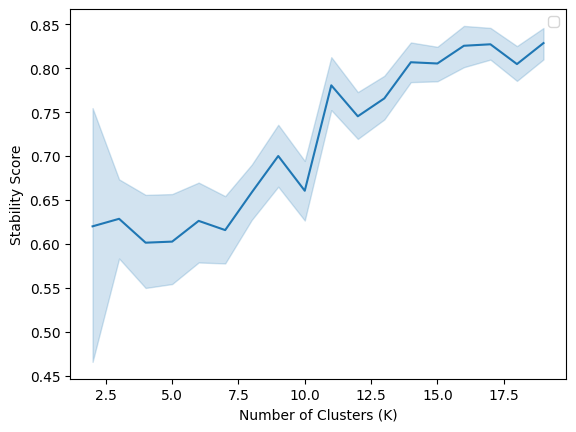

In [18]:
# Plot stability scores
import seaborn as sns
sns.lineplot(x=ks, y=stability_scores)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Stability Score")
plt.legend()
plt.show()

### Spectral clustering

- Find if they are stable clusters in the data?

In [195]:
np.random.seed(0)

KS = range(2, 20)
N_REPS = 5

ks = []
stability_scores = []

for k in tqdm(KS):
    labels = []
    
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding"
            + " may not work as expected.",
            category=UserWarning,
        )
        model = cluster.SpectralClustering(
            n_clusters=k, 
            affinity="nearest_neighbors", 
            n_init=1
        )
        predicted_labels = model.fit_predict(X_scaled)
        
        # compute pairwise adjusted Rand index (ARI) for stability
        ari_distances = ari(predicted_labels, y)
        
        ks.append(k)
        stability_scores.append(ari_distances)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [10:27<00:00, 34.89s/it]


/var/folders/rd/c2tlh0qn3y7fvt1bwwd_d2x80000gn/T/ipykernel_78001/1987375669.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


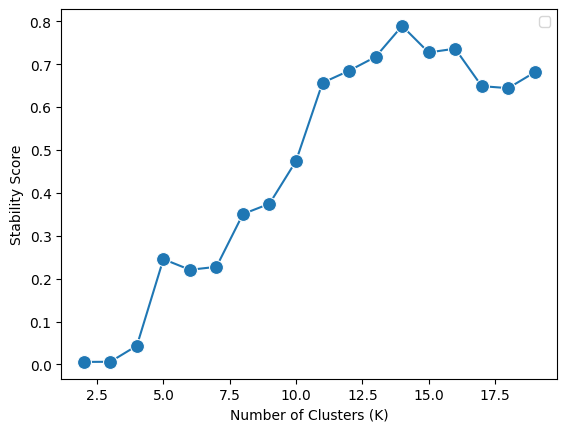

In [215]:
sns.lineplot(
    x=ks, 
    y=stability_scores, 
    marker="o", 
    markersize=10 
)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Stability Score")
plt.legend()
plt.show()

Answer:

K-mean clustering

For this clustering, the variation of cluster stability changes from clusters 8 onwards, in which it switches from wider interval to a narrower one. From this, we conclude that clusters from 0 to about 8 exhibit much greater variability in stability than the others. It is worth noting the jump in stability at k = 10 to 11. Additionally, It is worth mentioning that the stability of the models is generally high from k=2, max at clusters of about 20. From the plot of the stability curve, the best `k` is between `14` to `16`, reason been this clusters plateu, but no clear k outperform the other. So, for k mean clustering the no. of clusters equal to the number of tissues of origin in our data. 
Spectral clustering

For the spectral clustering, best on the ARI score, the optimal `k` is `14`. 
Conclusion

Based on the ARI score, the picked `k` range between `12` to `16`, thus not simillar to the number of tissue of origin (`10`) in our dataset. 

## 3. Cluster Evaluation and Interpretation


__Using external metrics, assess how well the clustering solutions match the true labels/targets (tissue of origin).___


####  K-mean evaluations

In [217]:
np.random.seed(0)

# external metrics
k_mean_perf_ari = {}
kmean_perf_nmi = {}

# internal metrics
kmean_perf_c = {}
kmean_perf_d = {}

for k in tqdm(KS):
    model = cluster.KMeans(n_clusters=k, n_init=10)
    predicted_labels = model.fit_predict(X_scaled)

    # internal metrics
    k_mean_perf_ari[k] = ari(predicted_labels, y)
    kmean_perf_nmi[k] = nmi(predicted_labels, y)

    # external metrics
    kmean_perf_c[k] = calinski_harabasz_score(X_scaled, predicted_labels)
    kmean_perf_d[k] = davies_bouldin_score(X_scaled, predicted_labels)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [08:17<00:00, 27.66s/it]


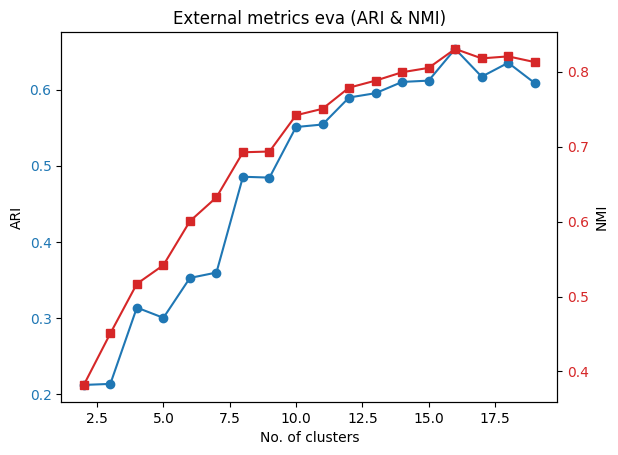

In [219]:
_tmp = pd.DataFrame(
    {
        "ari": k_mean_perf_ari,
        "nmi": kmean_perf_nmi,
    },
    index=KS,
)

fig, ax1 = plt.subplots()

# First axis (ARI)
ax1.set_xlabel("No. of clusters")
ax1.set_ylabel("ARI")
ax1.plot(_tmp.index, _tmp["ari"], marker="o", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Second axis (NMI)
ax2 = ax1.twinx()
ax2.set_ylabel("NMI")
ax2.plot(_tmp.index, _tmp["nmi"], marker="s", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("External metrics eva (ARI & NMI)")
plt.show()

__Using internal metrics, assess the quality of the clustering solutions.__

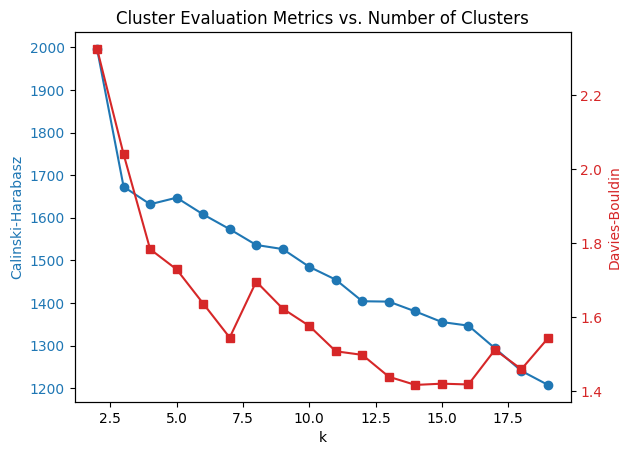

In [227]:
_tmp = pd.DataFrame(
    {
        "CH": kmean_perf_c,
        "DB": kmean_perf_d,
    },
    index=KS,
)

fig, ax1 = plt.subplots()

# First axis (CH)
ax1.set_xlabel("k")
ax1.set_ylabel("Calinski-Harabasz", color="tab:blue")
ax1.plot(_tmp.index, _tmp["CH"], marker="o", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Second axis (DB)
ax2 = ax1.twinx()
ax2.set_ylabel("Davies-Bouldin", color="tab:red")
ax2.plot(_tmp.index, _tmp["DB"], marker="s", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("Cluster Evaluation Metrics vs. Number of Clusters")
plt.show()

### Spectral clustering evaluations

In [218]:
np.random.seed(0)

# external metrics
spec_perf_ari = {}
spec_perf_nmi = {}

# internal metrics
spec_perf_c = {}
spec_perf_d = {}

for k in tqdm(KS):
    
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding"
            + " may not work as expected.",
            category=UserWarning,
        )
        model = cluster.SpectralClustering(
            n_clusters=k, 
            affinity="nearest_neighbors", 
            n_init=1
        )
        predicted_labels = model.fit_predict(X_scaled)
        
        # internal metrics
        spec_perf_ari[k] = ari(predicted_labels, y)
        spec_perf_nmi[k] = nmi(predicted_labels, y)
    
        # external metrics
        spec_perf_c[k] = calinski_harabasz_score(X_scaled, predicted_labels)
        spec_perf_d[k] = davies_bouldin_score(X_scaled, predicted_labels)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [10:44<00:00, 35.81s/it]


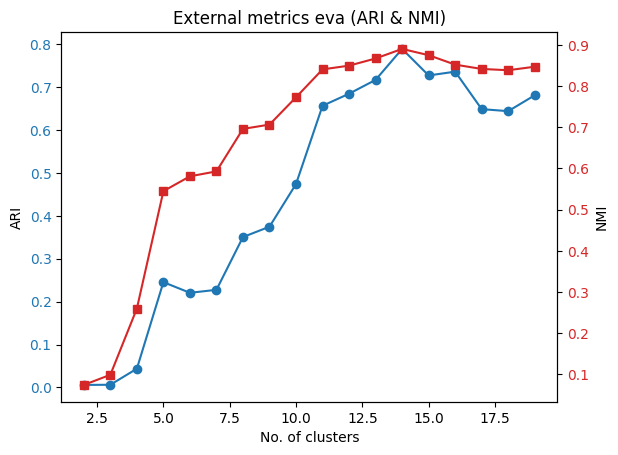

In [225]:
# internal metrics
_tmp = pd.DataFrame(
    {
        "ari": spec_perf_ari,
        "nmi": spec_perf_nmi,
    },
    index=KS,
)

fig, ax1 = plt.subplots()

# First axis (ARI)
ax1.set_xlabel("No. of clusters")
ax1.set_ylabel("ARI")
ax1.plot(_tmp.index, _tmp["ari"], marker="o", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Second axis (NMI)
ax2 = ax1.twinx()
ax2.set_ylabel("NMI")
ax2.plot(_tmp.index, _tmp["nmi"], marker="s", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("External metrics eva (ARI & NMI)")
plt.show()

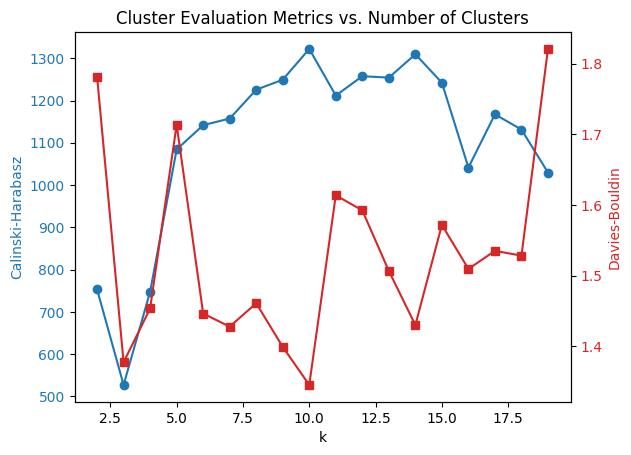

In [226]:
# external metrics
_tmp = pd.DataFrame(
    {
        "CH": spec_perf_c,
        "DB": spec_perf_d,
    },
    index=KS,
)

fig, ax1 = plt.subplots()

# First axis (CH)
ax1.set_xlabel("k")
ax1.set_ylabel("Calinski-Harabasz", color="tab:blue")
ax1.plot(_tmp.index, _tmp["CH"], marker="o", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Second axis (DB)
ax2 = ax1.twinx()
ax2.set_ylabel("Davies-Bouldin", color="tab:red")
ax2.plot(_tmp.index, _tmp["DB"], marker="s", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

plt.title("Cluster Evaluation Metrics vs. Number of Clusters")
plt.show()

__Answer__: 

__Kmean clustering__

Based on both ARI, and NMI scores, the optimal `K` is `16`. For internal metrics (`Calinski-Harabasz Index`, and `Davies-Bouldin Index`), the optimal `K` was not consistent across the metrics. For `Davies-Bouldin Index`, the k with lowest score is `14`, and for `Calinski-Harabasz`, the value with the highest score is `2`. From here, I can conclude that the optimal `K` is `16` based on the agreement of the ARI, and NMI score. 


__Spectral Clustering__

For spectral clustering, for ARI, and NMI scores, the optimal `K` is `14`, that has the highest score for all. For internal metrics, the optimal `K` is `10`, as it has the lowest `Davies-Bouldin` score and highest `Calinski-Harabasz` as expected. 

__Conclusion__

In general, the clustering done with `k-means` seemed unstable, as the internal, and external metrics did not concur as compared to `spectral clustering`. This could be explain by the behaviour of the `k-means` generating hyphersperical clusters. But the gene expression data could be very complex, and might require other geometries to capture the low dimensional data manifold.

Onwards, I will use `spectral clustering` and `k` equals `10` based on internal metrics.



__Identify the most important genes (features) that drive the clustering results. Explain your approach and findings.__

__Approach__

To identify top most important genes for clustering, I will do the following

1. Perform spectral clustering with `k` = `10` based on internal metrics as evaluated above.

2. Use the predicted clusters as labels for a RandomForestClassifier.

3. Plot the top 20, most important variables. 

In [232]:
# 1. Spectral clustering
k = 10
with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        message="Graph is not fully connected, spectral embedding"
        + " may not work as expected.",
        category=UserWarning,
    )
    model = cluster.SpectralClustering(
        n_clusters=k, 
        affinity="nearest_neighbors", 
        n_init=1
    )
    predicted_clusters = model.fit_predict(X_scaled)

In [245]:
# 2. Random Forest classification
clf_randf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_randf.fit(X_scaled, predicted_clusters)

RandomForestClassifier(random_state=42)

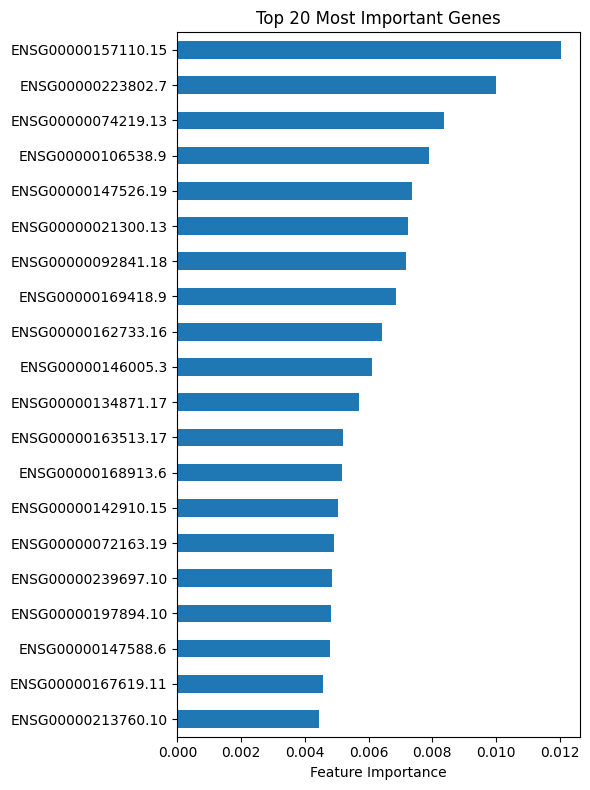

In [246]:
# 3. Visualization of top important features
features_names = prepped_data.drop(columns = ['tissue'], axis = 1).columns.to_list()
mdi_importances = pd.Series(clf_randf.feature_importances_, index=features_names)
top20 = mdi_importances.nlargest(20).sort_values()

fig, ax1 = plt.subplots(figsize=(6, 8))
top20.plot.barh(ax=ax1)
ax1.set_title("Top 20 Most Important Genes")
ax1.set_xlabel("Feature Importance")
plt.tight_layout()
plt.show()

__Explanation__

The top gene (ENSG00000157110.15), its function is RNA binding protein, and based on the [bgee website](https://www.bgee.org/), the expression is heterogenous across tissues.  The second top feature `ENSG00000223802.7` is highly related to brain development. 

Since RNA-binding protein is important in all tissues, it will make sense why it's the top gene that drives clustering. Although the second top gene show specialization towards brain development.


__Identify the most important genes for each tissue separately. Explain your approach and findings.__ 

__Approach__

To identify the most important genes for each tissues, I will perform use a logistic regression to find important genes for each class. I will turn the problem into a one vs other classification, and use lasso regularization to select the most important features. 

Tissue: Adipose Tissue
Tissue: Blood
Tissue: Blood Vessel
Tissue: Brain
Tissue: Colon
Tissue: Esophagus
Tissue: Heart
Tissue: Lung
Tissue: Muscle
Tissue: Skin


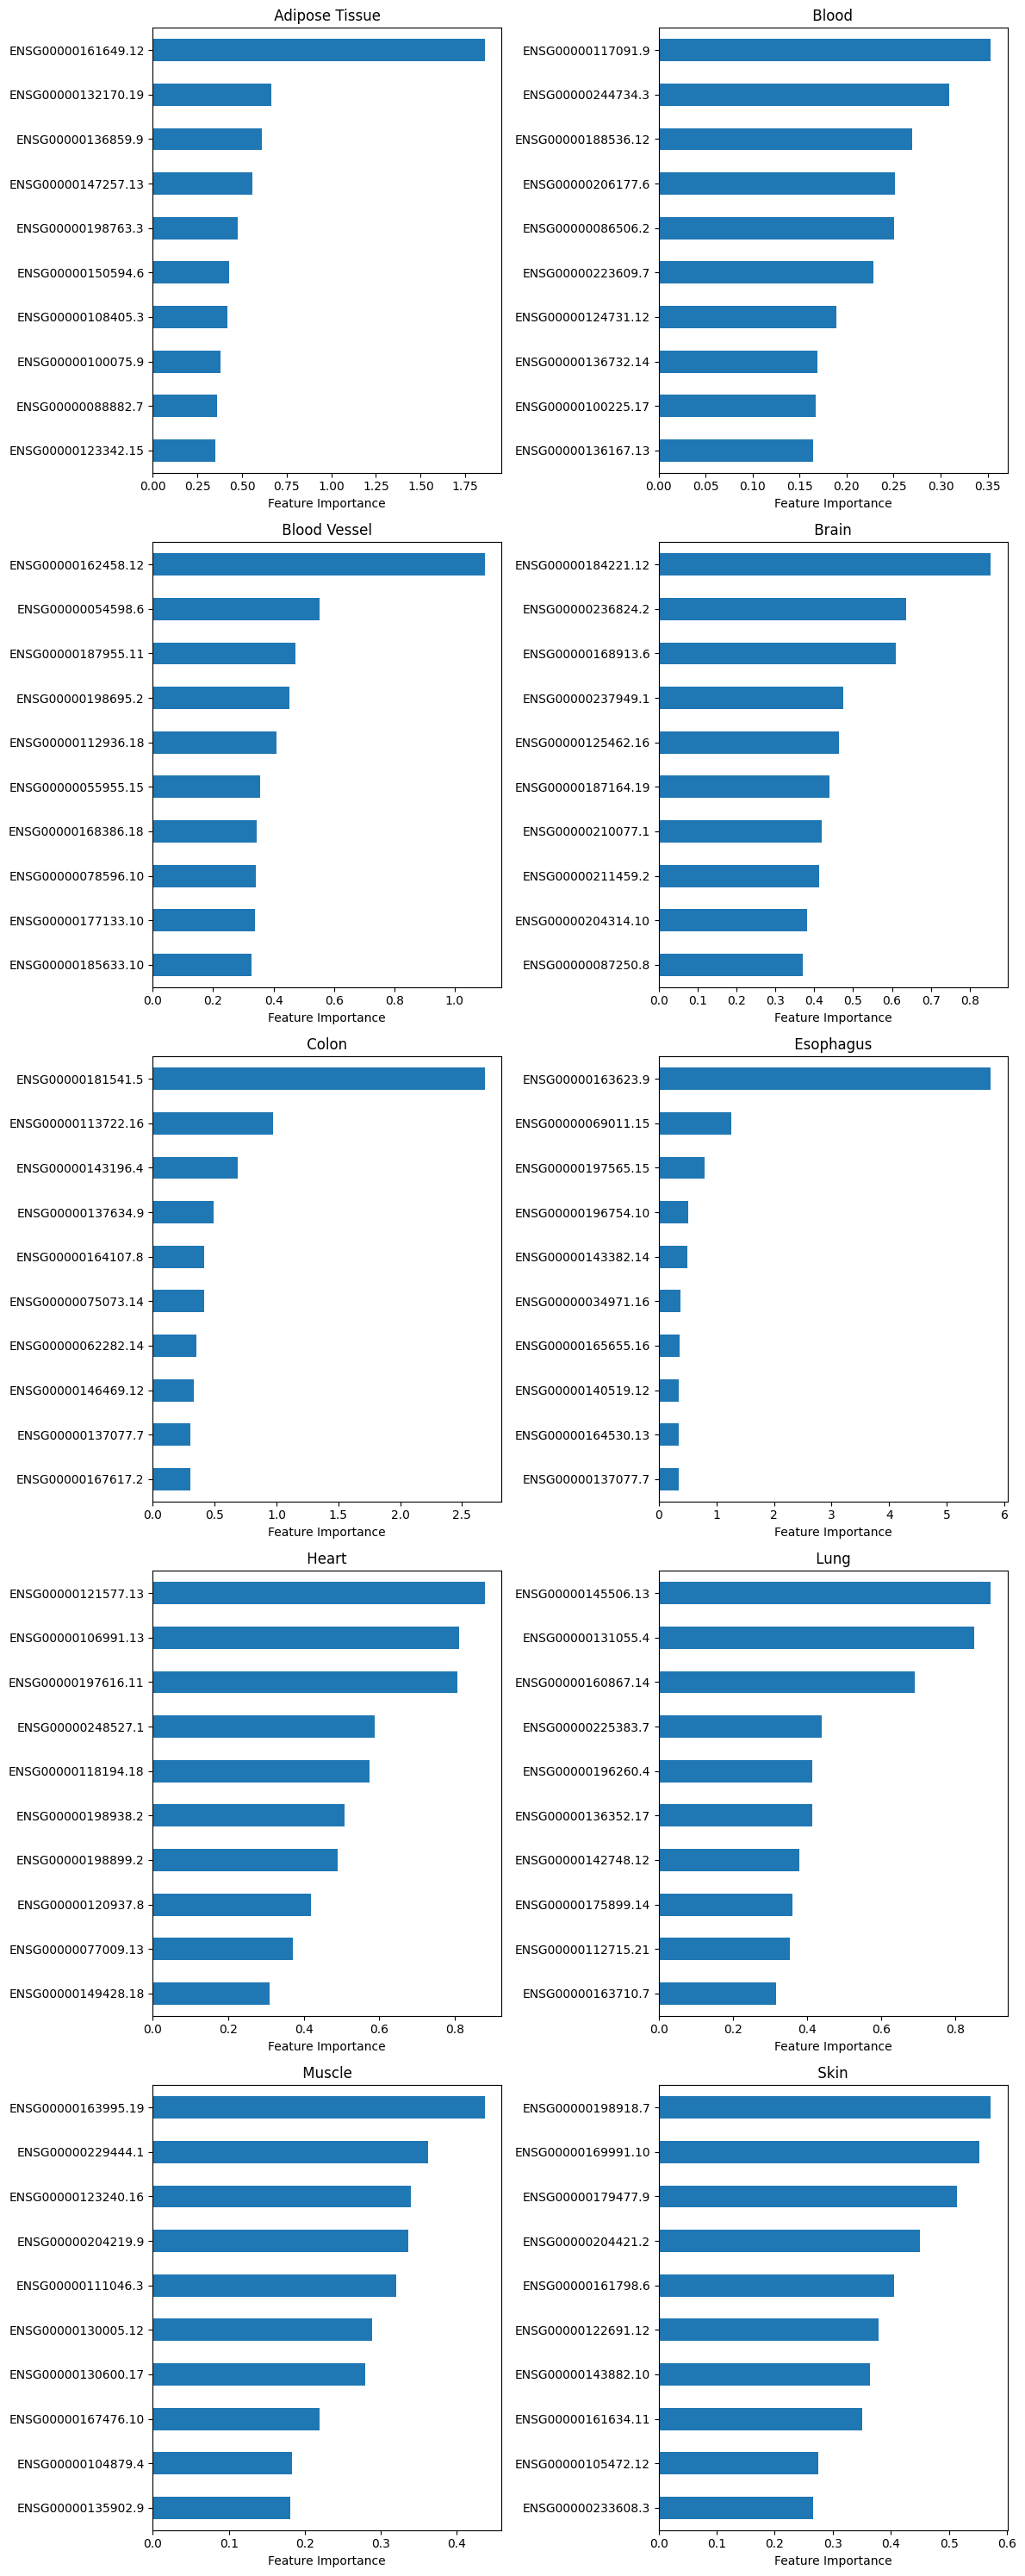

In [243]:
from collections import Counter
from sklearn.linear_model import LogisticRegression
import math
topk = 10

tissues = np.unique(y)
n_cols = 2
n_rows = math.ceil(len(tissues) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
axes = axes.flatten()


for ax, tissue in zip(axes, tissues):
    print(f"Tissue: {tissue}")
    y_ = np.array([t == tissue for t in y], dtype=int)
    clf = LogisticRegression(
        random_state=0, 
        penalty='l1', 
        solver = 'liblinear'
    ).fit(X_scaled, y_)
    # get the coefficients
    coeffs = clf.coef_.flatten()
    lasso_importances = pd.Series(coeffs, index=features_names)

    # get the top k coefficient corresponding to important features
    # for distinguishing between 0 vs 1 ( referring to tissue we are looking 
    # at currently ). 
    top_genes = lasso_importances.nlargest(topk).sort_values()
    top_genes.plot.barh(ax=ax)
    ax.set_title(f"{tissue}")
    ax.set_xlabel("Feature Importance")
    ax.set_title(f" {tissue} ")    

# Remove empty subplots if any
for i in range(len(tissues), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

__Explanation__: 

From the plot above, you can see the top genes per tissue. I went through the top gene for 3 tissues (heart, Esophagus, and Muscle). 

`heart`

- `ENSG00000121577.13`; correspond to [POPDC2](https://www.bgee.org/gene/ENSG00000121577), with highest expression score in heart related anatomical entities.

`Esophagus`

- `ENSG00000163623.9`; correspond to [NKX6-1](https://www.bgee.org/gene/ENSG00000163623) the highest expression score anatomical entity is lower esophagus muscularis layer. 


`muscle`

- `ENSG00000163995.19` correspond to [ABLIM2](https://www.bgee.org/gene/ENSG00000163995), described as ctin binding LIM protein family member 2. 


From this three top genes, we se from [bgee.org](www.bgee.org) website the corresponding anatomical entities with  highest expression scores are related to the tissue. Thus it suggest the lasso regularization was able to select genes able to distingish the tissues from others.